In [1]:
import os,sys
import os,sys,inspect
from glob import glob
from os.path import exists, join
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import argparse

import torch
import torchvision, torchvision.transforms
import skimage.transform
import sklearn, sklearn.model_selection
import train_utils
import random
import torchxrayvision as xrv

d:\machineLearning\miniconda\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import torchxrayvision as xrv
xrv.datasets

<module 'torchxrayvision.datasets' from 'd:\\machineLearning\\miniconda\\envs\\pytorch-gpu\\lib\\site-packages\\torchxrayvision\\datasets.py'>

In [3]:
datas = []
datas_names = []

transforms = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(512)])
data_aug = None
dataset = xrv.datasets.NIH_Dataset(
    imgpath="imgdata/images-NIH-224",
    transform=transforms, data_aug=data_aug, unique_patients=False, views=["PA","AP"])
datas.append(dataset)
datas_names.append("nih")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, dataset)
print("datas_names", datas_names)
print("--------------------------")
print("data_distribution", datas)

Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
datas_names ['nih']
--------------------------
data_distribution {'Atelectasis': {0.0: 100561, 1.0: 11559},
 'Cardiomegaly': {0.0: 109344, 1.0: 2776},
 'Consolidation': {0.0: 107453, 1.0: 4667},
 'Edema': {0.0: 109817, 1.0: 2303},
 'Effusion': {0.0: 98803, 1.0: 13317},
 'Emphysema': {0.0: 109604, 1.0: 2516},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 110434, 1.0: 1686},
 'Fracture': {},
 'Hernia': {0.0: 111893, 1.0: 227},
 'Infiltration': {0.0: 92226, 1.0: 19894},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 106338, 1.0: 5782},
 'Nodule': {0.0: 105789, 1.0: 6331},
 'Pleural_Thickening': {0.0: 108735, 1.0: 3385},
 'Pneumonia': {0.0: 110689, 1.0: 1431},
 'Pneumothorax': {0.0: 106818, 1.0: 5302}}
[NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None]


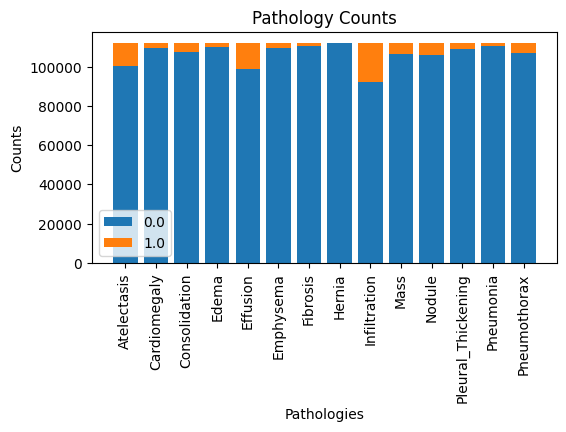

In [4]:
data = {'Atelectasis': {0.0: 100561, 1.0: 11559},
 'Cardiomegaly': {0.0: 109344, 1.0: 2776},
 'Consolidation': {0.0: 107453, 1.0: 4667},
 'Edema': {0.0: 109817, 1.0: 2303},
 'Effusion': {0.0: 98803, 1.0: 13317},
 'Emphysema': {0.0: 109604, 1.0: 2516},
 'Fibrosis': {0.0: 110434, 1.0: 1686},
 'Hernia': {0.0: 111893, 1.0: 227},
 'Infiltration': {0.0: 92226, 1.0: 19894},
 'Mass': {0.0: 106338, 1.0: 5782},
 'Nodule': {0.0: 105789, 1.0: 6331},
 'Pleural_Thickening': {0.0: 108735, 1.0: 3385},
 'Pneumonia': {0.0: 110689, 1.0: 1431},
 'Pneumothorax': {0.0: 106818, 1.0: 5302}}
# 提取数据
labels = list(data.keys())
values_0 = [v.get(0.0, 0) for v in data.values()]  # 处理空字典
values_1 = [v.get(1.0, 0) for v in data.values()]  # 处理空字典

# 绘制条形图
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(labels, values_0, label='0.0')
ax.bar(labels, values_1, bottom=values_0, label='1.0')
ax.set_xticklabels(labels, rotation=90)
# 添加标签和标题
plt.xlabel("Pathologies")
plt.ylabel("Counts")
plt.title("Pathology Counts")

# 添加图例
ax.legend()

# 显示图表
plt.show()
fig.savefig('resultat/data_nih.png', bbox_inches = 'tight')


In [5]:
#cut out training sets
train_datas = []
test_datas = []
for i, dataset in enumerate(datas):
        
    # give patientid if not exist
    if "patientid" not in dataset.csv:
        dataset.csv["patientid"] = ["{}-{}".format(dataset.__class__.__name__, i) for i in range(len(dataset))]
            
    gss = sklearn.model_selection.GroupShuffleSplit(train_size=0.8,test_size=0.2, random_state=0)
        
    train_inds, test_inds = next(gss.split(X=range(len(dataset)), groups=dataset.csv.patientid))
    train_dataset = xrv.datasets.SubsetDataset(dataset, train_inds)
    test_dataset = xrv.datasets.SubsetDataset(dataset, test_inds)
        
    train_datas.append(train_dataset)
    test_datas.append(test_dataset)

In [6]:
print("train_datas", train_datas)
print("test_datas", test_datas)

train_datas {'Atelectasis': {0.0: 80501, 1.0: 9363},
 'Cardiomegaly': {0.0: 87618, 1.0: 2246},
 'Consolidation': {0.0: 86091, 1.0: 3773},
 'Edema': {0.0: 87983, 1.0: 1881},
 'Effusion': {0.0: 79131, 1.0: 10733},
 'Emphysema': {0.0: 87858, 1.0: 2006},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 88515, 1.0: 1349},
 'Fracture': {},
 'Hernia': {0.0: 89675, 1.0: 189},
 'Infiltration': {0.0: 73894, 1.0: 15970},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 85292, 1.0: 4572},
 'Nodule': {0.0: 84769, 1.0: 5095},
 'Pleural_Thickening': {0.0: 87200, 1.0: 2664},
 'Pneumonia': {0.0: 88705, 1.0: 1159},
 'Pneumothorax': {0.0: 85637, 1.0: 4227}}
[SubsetDataset num_samples=89864
└ of NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None]
test_datas {'Atelectasis': {0.0: 20060, 1.0: 2196},
 'Cardiomegaly': {0.0: 21726, 1.0: 530},
 'Consolidation': {0.0: 21362, 1.0: 894},
 'Edema': {0.0: 21834, 1.0: 422},
 'Effusion': {0.0: 19672, 1.0: 2584},
 'Emphysema': {0.0: 21746, 1.0:

In [7]:
if len(datas) == 0:
    raise Exception("no dataset")
elif len(datas) == 1:
    train_dataset = train_datas[0]
    test_dataset = test_datas[0]
else:
    print("merge datasets")
    train_dataset = xrv.datasets.Merge_Dataset(train_datas)
    test_dataset = xrv.datasets.Merge_Dataset(test_datas)

In [8]:
print("train_dataset.labels.shape", train_dataset.labels.shape)
print("test_dataset.labels.shape", test_dataset.labels.shape)
print("train_dataset",train_dataset)
print("test_dataset",test_dataset)

train_dataset.labels.shape (89864, 18)
test_dataset.labels.shape (22256, 18)
train_dataset {'Atelectasis': {0.0: 80501, 1.0: 9363},
 'Cardiomegaly': {0.0: 87618, 1.0: 2246},
 'Consolidation': {0.0: 86091, 1.0: 3773},
 'Edema': {0.0: 87983, 1.0: 1881},
 'Effusion': {0.0: 79131, 1.0: 10733},
 'Emphysema': {0.0: 87858, 1.0: 2006},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 88515, 1.0: 1349},
 'Fracture': {},
 'Hernia': {0.0: 89675, 1.0: 189},
 'Infiltration': {0.0: 73894, 1.0: 15970},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 85292, 1.0: 4572},
 'Nodule': {0.0: 84769, 1.0: 5095},
 'Pleural_Thickening': {0.0: 87200, 1.0: 2664},
 'Pneumonia': {0.0: 88705, 1.0: 1159},
 'Pneumothorax': {0.0: 85637, 1.0: 4227}}
SubsetDataset num_samples=89864
└ of NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None
test_dataset {'Atelectasis': {0.0: 20060, 1.0: 2196},
 'Cardiomegaly': {0.0: 21726, 1.0: 530},
 'Consolidation': {0.0: 21362, 1.0: 894},
 'Edema': {0.0: 21834, 1

In [47]:
model_path = "train_output/nih-resnet50-test-best.pt"
model = torch.load(model_path)

In [10]:
def valid_test_epoch(name, epoch, model, device, data_loader, criterion, limit=None):
    model.eval()

    avg_loss = []
    task_outputs={}
    task_targets={}
    for task in range(data_loader.dataset[0]["lab"].shape[0]):
        task_outputs[task] = []
        task_targets[task] = []
        
    with torch.no_grad():
        t = tqdm(data_loader)
        for batch_idx, samples in enumerate(t):

            if limit and (batch_idx > limit):
                print("breaking out")
                break
            
            images = samples["img"].to(device)
            targets = samples["lab"].to(device)

            outputs = model(images)
            
            loss = torch.zeros(1).to(device).double()
            for task in range(targets.shape[1]):
                task_output = outputs[:,task]
                task_target = targets[:,task]
                mask = ~torch.isnan(task_target)
                task_output = task_output[mask]
                task_target = task_target[mask]
                if len(task_target) > 0:
                    loss += criterion(task_output.double(), task_target.double())
                
                task_outputs[task].append(task_output.detach().cpu().numpy())
                task_targets[task].append(task_target.detach().cpu().numpy())

            loss = loss.sum()
            
            avg_loss.append(loss.detach().cpu().numpy())
            t.set_description(f'Epoch {epoch + 1} - {name} - Loss = {np.mean(avg_loss):4.4f}')
            
        for task in range(len(task_targets)):
            task_outputs[task] = np.concatenate(task_outputs[task])
            task_targets[task] = np.concatenate(task_targets[task])
    
        results = []
        #result["Pathology"] = model.pathologies[i]
        task_aucs = []
        for task in range(len(task_targets)):
            result = {}
            result["Pathology"] = test_dataset.pathologies[task]
            #print(test_dataset.pathologies[task])
            if len(np.unique(task_targets[task]))> 1:
                #print(task_targets[task])
                #print(task_outputs[task])
                task_auc = sklearn.metrics.roc_auc_score(task_targets[task], task_outputs[task])
                #task_acc = sklearn.metrics.accuracy_score(task_targets[task], task_outputs[task] > 0.5)#add
                #task_f1 = sklearn.metrics.f1_score(task_targets[task], task_outputs[task] > 0.5)#add
                result["AUC"] = task_auc
                result["Acc"] = sklearn.metrics.accuracy_score(task_targets[task], task_outputs[task] > 0.5)
                result["F1"] = sklearn.metrics.f1_score(task_targets[task], task_outputs[task] > 0.5)

                #print(task, task_auc)
                task_aucs.append(task_auc)
            else:
                task_aucs.append(np.nan)
            results.append(result)

    task_aucs = np.asarray(task_aucs)
    auc = np.mean(task_aucs[~np.isnan(task_aucs)])
    print(f'Epoch {epoch + 1} - {name} - Avg AUC = {auc:4.4f}')

    return auc, task_aucs, task_outputs, task_targets, results


In [48]:
# Dataloader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=8,
                                            shuffle=None,
                                            num_workers=0, pin_memory=False)
auc, task_aucs, task_outputs, task_targets, result_all_task = valid_test_epoch("test", 0, model, "cuda", test_loader, torch.nn.BCEWithLogitsLoss(), limit=10000000)

Epoch 1 - test - Loss = 2.2085: 100%|██████████| 2782/2782 [12:32<00:00,  3.70it/s]


Epoch 1 - test - Avg AUC = 0.8100


In [39]:
result_all_task

[{'Pathology': 'Atelectasis',
  'AUC': 0.7510930664291278,
  'Acc': 0.9012401150251618,
  'F1': 0.0009090909090909092},
 {'Pathology': 'Consolidation',
  'AUC': 0.7707269457756742,
  'Acc': 0.9598310567936736,
  'F1': 0.0},
 {'Pathology': 'Infiltration',
  'AUC': 0.6764394861188681,
  'Acc': 0.8235981308411215,
  'F1': 0.011581067472306143},
 {'Pathology': 'Pneumothorax',
  'AUC': 0.7948430306670196,
  'Acc': 0.9516534867002157,
  'F1': 0.0},
 {'Pathology': 'Edema',
  'AUC': 0.876002990249131,
  'Acc': 0.9809040258806614,
  'F1': 0.0},
 {'Pathology': 'Emphysema',
  'AUC': 0.8130562212928949,
  'Acc': 0.9770848310567937,
  'F1': 0.0},
 {'Pathology': 'Fibrosis',
  'AUC': 0.7193767638958815,
  'Acc': 0.9848580158159598,
  'F1': 0.0},
 {'Pathology': 'Effusion',
  'AUC': 0.8507363741364572,
  'Acc': 0.8896477354421279,
  'F1': 0.2733727810650888},
 {'Pathology': 'Pneumonia',
  'AUC': 0.711296885702971,
  'Acc': 0.9877785765636233,
  'F1': 0.0},
 {'Pathology': 'Pleural_Thickening',
  'AUC': 

In [44]:
import pandas as pd
pd.DataFrame(result_all_task)

,Pathology,AUC,Acc,F1
0,Atelectasis,0.751093,0.901240,0.000909
1,Consolidation,0.770727,0.959831,0.000000
2,Infiltration,0.676439,0.823598,0.011581
3,Pneumothorax,0.794843,0.951653,0.000000
4,Edema,0.876003,0.980904,0.000000
5,Emphysema,0.813056,0.977085,0.000000
6,Fibrosis,0.719377,0.984858,0.000000
7,Effusion,0.850736,0.889648,0.273373
8,Pneumonia,0.711297,0.987779,0.000000
9,Pleural_Thickening,0.727576,0.967604,0.000000


In [41]:
auc

0.7745679402150462

In [42]:
task_aucs

array([0.75109307, 0.77072695, 0.67643949, 0.79484303, 0.87600299,
       0.81305622, 0.71937676, 0.85073637, 0.71129689, 0.72757634,
       0.88627442, 0.6556183 , 0.7844562 , 0.82645413,        nan,
              nan,        nan,        nan])

In [33]:
results = result_all_task
perf_dict = {}
all_threshs = []
all_min = []
all_max = []
all_ppv80 = []
file = open('resultat/nih-resnet50-test-best','a')
for i, patho in enumerate(test_dataset.pathologies):
    opt_thres = np.nan
    opt_min = np.nan
    opt_max = np.nan
    ppv80_thres = np.nan
    if (len(results[3][i]) > 0) and (len(np.unique(results[3][i])) == 2):
        
        #sigmoid
        all_outputs = 1.0/(1.0 + np.exp(-results[2][i]))
        
        fpr, tpr, thres = sklearn.metrics.roc_curve(results[3][i], all_outputs)
        pente = tpr - fpr
        opt_thres = thres[np.argmax(pente)]
        opt_min = all_outputs.min()
        opt_max = all_outputs.max()
        
        ppv, recall, thres = sklearn.metrics.precision_recall_curve(results[3][i], all_outputs)
        ppv80_thres_idx = np.where(ppv > 0.8)[0][0]
        ppv80_thres = thres[ppv80_thres_idx-1]
        
        auc = sklearn.metrics.roc_auc_score(results[3][i], all_outputs)
        
        
        print(patho, auc)
        file.write(str(patho) + ' ' + str(auc) + '\n')
        perf_dict[patho] = str(round(auc,2))
        
    else:
        perf_dict[patho] = "-"
        
    all_threshs.append(opt_thres)
    all_min.append(opt_min)
    all_max.append(opt_max)
    all_ppv80.append(ppv80_thres)


file.write("pathologies" + str(test_dataset.pathologies) +'\n')
file.write("op_threshs" + str(all_threshs)+'\n')
file.write("min" + str(all_min)+'\n')
file.write("max" + str(all_max)+'\n')
file.write("ppv80" + str(all_ppv80)+'\n')
file.close()

print("-----------------------------------------------------------")    
print("pathologies",test_dataset.pathologies)
    
print("op_threshs",str(all_threshs).replace("nan","np.nan"))
    
print("min",str(all_min).replace("nan","np.nan"))
    
print("max",str(all_max).replace("nan","np.nan"))

print("ppv80",str(all_ppv80).replace("nan","np.nan"))

KeyError: 0

[0.75, 0.77, 0.68, 0.79, 0.88, 0.81, 0.72, 0.85, 0.71, 0.73, 0.89, 0.66, 0.78, 0.83]


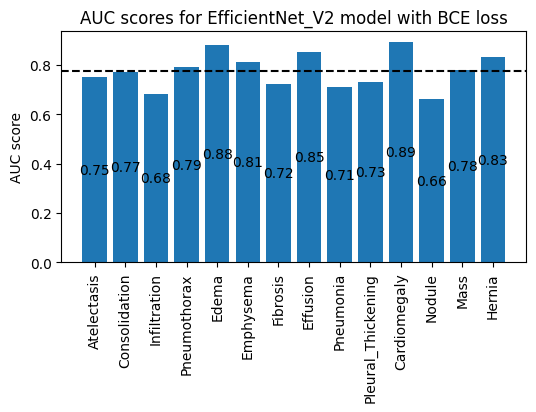

In [43]:
from decimal import Decimal
# 定义AUC得分
auc_scores = [0.75109307, 0.77072695, 0.67643949, 0.79484303, 0.87600299,
       0.81305622, 0.71937676, 0.85073637, 0.71129689, 0.72757634,
       0.88627442, 0.6556183 , 0.7844562 , 0.82645413]

auc_scores = [float('{:.2f}'.format(i)) for i in auc_scores]
print(auc_scores)
mean_auc = np.mean(auc_scores)
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
                    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
                    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# 创建图像
fig, ax = plt.subplots(figsize=(6, 3))

# 绘制条形图
ax.bar(range(len(auc_scores)), auc_scores)

# 添加x轴标签
ax.set_xticks(range(len(auc_scores)))
ax.set_xticklabels(['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
                    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
                    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'], rotation=90)

# 添加y轴标签
ax.set_ylabel('AUC score')

# 添加平均AUC值的虚线
ax.axhline(y=mean_auc, color='black', linestyle='--')

plt.bar_label(ax.containers[0], label_type='center')

# 设置图像标题
ax.set_title('AUC scores for EfficientNet_V2 model with BCE loss')

# 显示图像
plt.show()

fig.savefig('resultat/AUC EfficientNet_V2 BCE.png', bbox_inches = 'tight')

[0.75, 0.77, 0.67, 0.8, 0.87, 0.81, 0.73, 0.85, 0.69, 0.74, 0.9, 0.69, 0.78, 0.84]


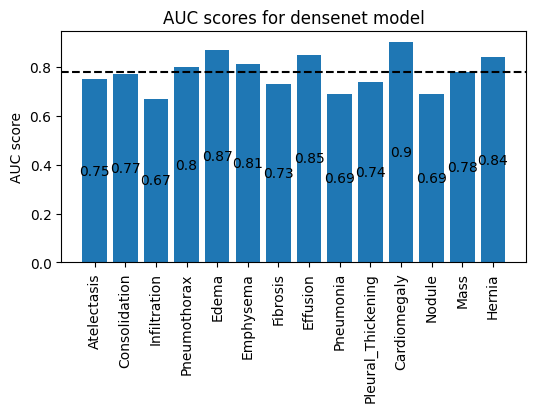

In [43]:
from decimal import Decimal
# 定义AUC得分
auc_scores = [ 0.7541618654964071,
 0.772886140624375,
 0.6731721509131717,
 0.8035080145325506,
 0.8655889961610376,
 0.8068768112413731,
 0.7284544268261496,
 0.8480097004181267,
 0.6922867366105832,
 0.7364309045011717,
 0.9017401114046469,
 0.6917252100788585,
 0.7811632802762623,
 0.8362956066915872]

auc_scores = [float('{:.2f}'.format(i)) for i in auc_scores]
print(auc_scores)
mean_auc = np.mean(auc_scores)
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
                    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
                    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# 创建图像
fig, ax = plt.subplots(figsize=(6, 3))

# 绘制条形图
ax.bar(range(len(auc_scores)), auc_scores)

# 添加x轴标签
ax.set_xticks(range(len(auc_scores)))
ax.set_xticklabels(['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
                    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
                    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'], rotation=90)

# 添加y轴标签
ax.set_ylabel('AUC score')

# 添加平均AUC值的虚线
ax.axhline(y=mean_auc, color='black', linestyle='--')

plt.bar_label(ax.containers[0], label_type='center')

# 设置图像标题
ax.set_title('AUC scores for densenet model')

# 显示图像
plt.show()

fig.savefig('resultat/AUC densenet.png', bbox_inches = 'tight')